# RAFT

In [1]:
! pip install -r ../requirements.txt

## Synthetic data generation phase

### Select the documents

In [2]:
import pandas as pd
ds_name = "bats-DEMO"
doc_path = "../sample_data/vampire-bats/bats/Desmodus draculae - Wikipedia.pdf"
ds_path = f"dataset/{ds_name}"
print("Creating dataset: " + ds_name)

Creating dataset: bats-DEMO


### Overview of PDF

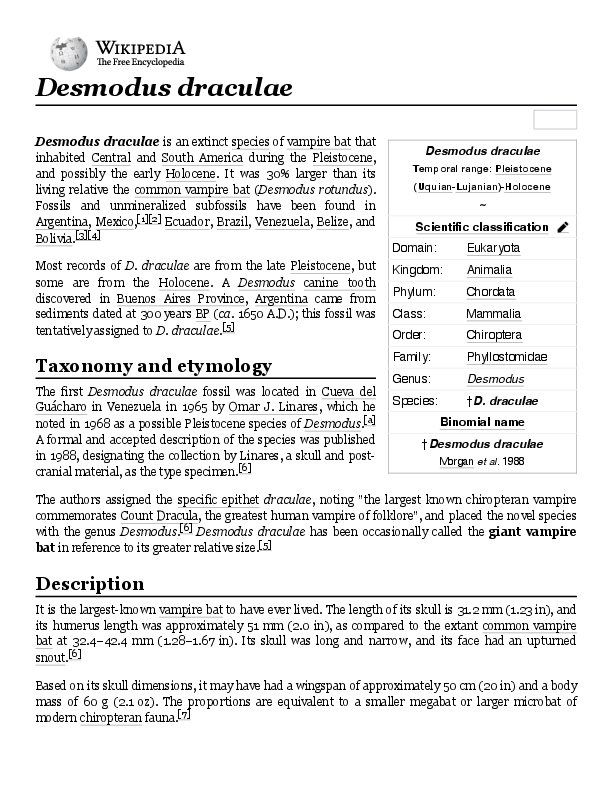

In [3]:
from wand.image import Image as WImage
img = WImage(filename=doc_path)

# make background of img white
img.format = 'png'
img.background_color = 'white'
img.alpha_channel = 'remove'
img

### Clean up the DEMO folder

In [4]:
# Clean up demo folder only if it's a DEMO dataset
if ds_path.endswith("DEMO"):
    import shutil
    print(f"Cleaning demo folder {ds_path}")
    shutil.rmtree(ds_path, ignore_errors=True)
    print(f"Cleaning demo checkpoints folder {ds_path}")
    shutil.rmtree(ds_path + "-checkpoints", ignore_errors=True)

Cleaning demo folder dataset/bats-DEMO
Cleaning demo checkpoints folder dataset/bats-DEMO


### Generate Q/A/CoT fine-tuning dataset using RAFT from the domain specific documents

In [5]:
! python3 ../raft.py \
    --datapath "$doc_path" \
    --output $ds_path \
    --distractors 3 \
    --doctype pdf \
    --chunk_size 512 \
    --questions 1 \
    --workers 2 \
    --system-prompt-key llama \
    --completion_model Meta-Llama-3-70B-Instruct \
    --embedding_model text-embedding-ada-002

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
2024-05-29 08:56:15  INFO [  0%] raft Using checkpoint chunks /workspaces/gorilla/raft/azure-ai-studio-ft/dataset/bats-DEMO-checkpoints/chunks
2024-05-29 08:56:15  INFO [  0%] raft Retrieving chunks from ../sample_data/vampire-bats/bats/Desmodus draculae - Wikipedia.pdf of type pdf using the text-embedding-ada-002 model.
Chunking: 100%|██████████████████████| 1/1 [00:00<00:00,  1.39file/s, chunks=10]
2024-05-29 08:56:15  INFO [  0%] raft Using system prompt key llama
2024-05-29 08:56:15  INFO [  0%] raft Using 2 worker threads
Generating: 100%|█| 10/10 [01:41<00:00, 10.12s/chunk, qa=11, last tok/s=4.79e+4,
2024-05-29 08:57:57  INFO [  0%] raft Consumed 9146 prompt tokens, 2443 completion tokens, 11589 total tokens
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 263.28ba/s]
2024-05-29 08:57:57  INFO [  0%] raf

## Prepare training, validation and evaluation splits

In [6]:
raft_arrow_file = f"{ds_path}/data-00000-of-00001.arrow"
dataset_path = f"{ds_path}-files/{ds_name}-full.jsonl"
dataset_path_hf = f"{ds_path}-files/{ds_name}-hf.full.jsonl"

dataset_path_hf_train = f"{ds_path}-files/{ds_name}-hf.train.jsonl"
dataset_path_hf_valid = f"{ds_path}-files/{ds_name}-hf.valid.jsonl"
dataset_path_hf_eval = f"{ds_path}-files/{ds_name}-hf.eval.jsonl"

dataset_path_ft_train = f"{ds_path}-files/{ds_name}-ft.train.jsonl"
dataset_path_ft_valid = f"{ds_path}-files/{ds_name}-ft.valid.jsonl"
dataset_path_ft_eval = f"{ds_path}-files/{ds_name}-ft.eval.jsonl"

print(f"Reading arrow file {raft_arrow_file}")

Reading arrow file dataset/bats-DEMO/data-00000-of-00001.arrow


### Export dataset to JSONL

In [7]:
! python ../format.py \
    --input $raft_arrow_file \
    --output $dataset_path_hf \
    --output-format hf

Generating train split: 11 examples [00:00, 3819.32 examples/s]
2024-05-29 08:58:00  INFO [    ] raft Dataset has 11 rows
2024-05-29 08:58:00  INFO [    ] raft Converting arrow file dataset/bats-DEMO/data-00000-of-00001.arrow to jsonl hf file dataset/bats-DEMO-files/bats-DEMO-hf.full.jsonl
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 129.50ba/s]


In [8]:
hf_full_df = pd.read_json(dataset_path_hf, lines=True)
hf_full_df.head(5)

,id,type,question,context,oracle_context,cot_answer,instruction
0,bd473f56-72d8-4763-a512-3b7f71914ae2,general,Who is S. Turvey?,"{'sentences': [['(2008). ""Desmodus draculae (G...","Turvey, S.","To answer the question, we need to identify wh...","<DOCUMENT>(2008). ""Desmodus draculae (Giant Va..."
1,576c7c9f-300d-402d-9c92-26f34999a7d2,general,What was the estimated wingspan of D. draculae?,{'sentences': [['The date and reason for its e...,"Its skull was long and narrow, and its face ha...","To answer the question, we need to identify th...",<DOCUMENT>The date and reason for its extincti...
2,9daab9e2-55cc-40df-8661-9febb4ad848d,general,What family does the vampire bat belong to?,"{'sentences': [['(2008). ""Desmodus draculae (G...","(2002). ""The northernmost occurrence ofthe Ple...","To answer the question, we need to identify th...","<DOCUMENT>(2008). ""Desmodus draculae (Giant Va..."
3,0aa56ed2-5b51-4e14-8b33-817111b36379,general,What year was the report on the late Quaternar...,{'sentences': [['Its skull was long and narrow...,"Arroyo-Cabrales, Joaquin; Alvarez, Ticul (2003...","To answer the question, we need to identify th...","<DOCUMENT>Its skull was long and narrow, and i..."
4,e7543972-9a8c-493a-a194-8ab4ee15011f,general,What is the scientific classification of Desmo...,"{'sentences': [['Turvey, S.', '(2008). ""Desmod...",Desmodus draculaeTemporal range: Pleistocene(U...,"To answer the question, we need to identify th...","<DOCUMENT>Turvey, S.</DOCUMENT>\n<DOCUMENT>(20..."


### Do the splitting

In [9]:
# split dataset into 80%/10%/10%
import numpy as np
samples_count = len(hf_full_df)
hf_train_df, hf_valid_df, hf_eval_df = np.split(hf_full_df, [int(.8*samples_count), int(.9*samples_count)])
hf_train_df.to_json(dataset_path_hf_train, orient="records", lines=True)
hf_valid_df.to_json(dataset_path_hf_valid, orient="records", lines=True)
hf_eval_df.to_json(dataset_path_hf_eval, orient="records", lines=True)

/workspaces/gorilla/raft/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Export training and validation datasets into JSONL format

In [10]:
! python ../format.py \
    --input $dataset_path_hf_train \
    --input-type jsonl \
    --output $dataset_path_ft_train \
    --output-format completion \
    --output-completion-prompt-column text\
    --output-completion-completion-column ground_truth

Generating train split: 8 examples [00:00, 1754.11 examples/s]
2024-05-29 08:58:02  INFO [    ] raft Dataset has 8 rows
2024-05-29 08:58:02  INFO [    ] raft Converting jsonl file dataset/bats-DEMO-files/bats-DEMO-hf.train.jsonl to jsonl completion file dataset/bats-DEMO-files/bats-DEMO-ft.train.jsonl
Filter out empty examples: 100%|█████████| 8/8 [00:00<00:00, 1623.18 examples/s]
Rename fields and add <STOP> token: 100%|█| 8/8 [00:00<00:00, 3132.12 examples/s
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 415.20ba/s]


In [11]:
! python ../format.py \
    --input $dataset_path_hf_valid \
    --input-type jsonl \
    --output $dataset_path_ft_valid \
    --output-format completion \
    --output-completion-prompt-column text\
    --output-completion-completion-column ground_truth

Generating train split: 1 examples [00:00, 202.79 examples/s]
2024-05-29 08:58:04  INFO [    ] raft Dataset has 1 rows
2024-05-29 08:58:04  INFO [    ] raft Converting jsonl file dataset/bats-DEMO-files/bats-DEMO-hf.valid.jsonl to jsonl completion file dataset/bats-DEMO-files/bats-DEMO-ft.valid.jsonl
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 379.13ba/s]


In [12]:
dataset_path_ft_valid_df = pd.read_json(dataset_path_ft_valid, lines=True)
dataset_path_ft_valid_df.head(2)

,text,ground_truth
0,"<DOCUMENT>Turvey, S.</DOCUMENT>\n<DOCUMENT>dra...","To answer the question, we need to identify th..."


### Export evaluation dataset into JSONL format

In [13]:
! python ../format.py \
    --input $dataset_path_hf_eval \
    --input-type jsonl \
    --output $dataset_path_ft_eval \
    --output-format eval

Generating train split: 2 examples [00:00, 413.01 examples/s]
2024-05-29 08:58:06  INFO [    ] raft Dataset has 2 rows
2024-05-29 08:58:06  INFO [    ] raft Converting jsonl file dataset/bats-DEMO-files/bats-DEMO-hf.eval.jsonl to jsonl eval file dataset/bats-DEMO-files/bats-DEMO-ft.eval.jsonl
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 449.26ba/s]


In [14]:
dataset_path_ft_eval_df = pd.read_json(dataset_path_ft_eval, lines=True)
dataset_path_ft_eval_df.head(2)

,question,gold_final_answer,context
0,What is the current status of knowledge on the...,Unknown,<DOCUMENT>The date and reason for its extincti...
1,What is the size of the Caoera bat in Mura peo...,the size of a vulture,"<DOCUMENT>draculae include plains viscacha, de..."
